In [118]:
import numpy as np
import pandas as pd

import h5py
import os
import sys
from tqdm import tqdm
import itertools

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import gridspec

import astropy.units as u
import astropy.constants as C
import peters
from IPython.core.debugger import set_trace
from importlib import reload

colors = sns.color_palette("colorblind", n_colors=10)
colors = [colors[0], colors[2], colors[4], colors[1], colors[3], colors[6], colors[9], colors[5], colors[8]]

plt.style.use("/Users/michaelzevin/.MATPLOTLIB_RCPARAMS.sty")

In [2]:
hyperparam_dict = {'p0':{0:r'$\chi_\mathrm{b}=0.0$', 1:r'$\chi_\mathrm{b}=0.1$', 2:r'$\chi_\mathrm{b}=0.2$', 3:r'$\chi_\mathrm{b}=0.5$'}, 
                   'p1':{0:r'$\alpha_\mathrm{CE}=0.2$', 1:r'$\alpha_\mathrm{CE}=0.5$', 2:r'$\alpha_\mathrm{CE}=1.0$', 3:r'$\alpha_\mathrm{CE}=2.0$', 4:r'$\alpha_\mathrm{CE}=5.0$'}, 
                   'beta_CE': r'$\beta_\mathrm{CE}$', 'beta_CHE': r'$\beta_\mathrm{CHE}$', 'beta_GC': r'$\beta_\mathrm{GC}$', 'beta_NSC': r'$\beta_\mathrm{NSC}$', 'beta_SMT': r'$\beta_\mathrm{SMT}$'}

In [217]:
data_path = '/Users/michaelzevin/research/model_selection/model_selection/trials/gwobs'
data_path_CEGC = '/Users/michaelzevin/research/model_selection/model_selection/trials/gwobs_CEGC'
data_path_CESMT = '/Users/michaelzevin/research/model_selection/model_selection/trials/gwobs_CESMT'

fig_path = '/Users/michaelzevin/research/model_selection/model_selection/paper/figures/'

In [218]:
# get the hdf5 files for default runs
run_files = os.listdir(data_path)
sample_files = []
for file in run_files:
    if '.hdf5' in file:
        sample_files.append(file)
        
samples = pd.DataFrame()

for file in sample_files:
    tmp = pd.read_hdf(os.path.join(data_path, file), key='model_selection/samples')
    samples = samples.append(tmp)
    
samples = samples.reset_index(drop=True)


# also get detectable samples for this run
run_files = os.listdir(data_path)
sample_files = []
for file in run_files:
    if '.hdf5' in file:
        sample_files.append(file)

samples_detectable = pd.DataFrame()

for file in sample_files:
    tmp = pd.read_hdf(os.path.join(data_path, file), key='model_selection/detectable_samples')
    samples_detectable = samples_detectable.append(tmp)
    
samples_detectable = samples_detectable.reset_index(drop=True)



# get the hdf5 files for 2-channel runs
run_files = os.listdir(data_path_CEGC)
sample_files = []
for file in run_files:
    if '.hdf5' in file:
        sample_files.append(file)
        
samples_CEGC = pd.DataFrame()

for file in sample_files:
    tmp = pd.read_hdf(os.path.join(data_path_CEGC, file), key='model_selection/samples')
    samples_CEGC = samples_CEGC.append(tmp)
    
samples_CEGC = samples_CEGC.reset_index(drop=True)


# get the hdf5 files for the 2-channel CESMT run
run_files = os.listdir(data_path_CESMT)
sample_files = []
for file in run_files:
    if '.hdf5' in file:
        sample_files.append(file)
        
samples_CESMT = pd.DataFrame()

for file in sample_files:
    tmp = pd.read_hdf(os.path.join(data_path_CESMT, file), key='model_selection/samples')
    samples_CESMT = samples_CESMT.append(tmp)
    
samples_CESMT = samples_CESMT.reset_index(drop=True)

In [284]:
def twochannel_branching_fractions(samples, hyperidx, prior_path, labelsize=40, ticksize=30, legendsize=25):
    beta_keys = sorted([key for key in list(samples.keys()) if 'beta' in key])
    hyperidx_key = 'p'+str(int(hyperidx))

    
    fig = plt.figure(figsize=(12,8))
    gs = gridspec.GridSpec(2,2, hspace=0.6)
    
    beta_axs = []
    for idx in np.arange(len(beta_keys)):
        beta_axs.append(fig.add_subplot(gs[0,idx]))

    Bmax_ax = fig.add_subplot(gs[1,:])
    

    ### TOP ROW
    # loop through hyperparameter values
    for (hkey, hval) in hyperparam_dict[hyperidx_key].items():
        samples_in_hypermodel = samples.loc[samples[hyperidx_key]==hkey]

        # loops through channels
        for idx, beta in enumerate(beta_keys):
            if idx==0:
                h, bins = np.histogram(samples_in_hypermodel[beta], bins=100, range=(0,1))
                h = np.append(h, [0])
                beta_axs[idx].step(bins, h/len(samples), lw=4, alpha=0.5, color=colors[hkey], label=hval)
            else:
                h, bins = np.histogram(samples_in_hypermodel[beta], bins=100, range=(0,1))
                h = np.append(h, [0])
                beta_axs[idx].step(bins, h/len(samples), lw=4, alpha=0.5, color=colors[hkey])
                
                
    # plot total branching fraction
    for idx, beta in enumerate(beta_keys):
        h, bins = np.histogram(samples[beta], bins=100, range=(0,1))
        h = np.append(h, [0])
        beta_axs[idx].step(bins, h/len(samples), color='k', alpha=1.0, lw=3, linestyle='--', zorder=-10)
        med = np.median(samples[beta])
        low90 = np.percentile(samples[beta],5)
        high90 = np.percentile(samples[beta],95)
        print("{:s}: {:0.3f}-{:0.3f}+{:0.3f}".format(beta, med, med-low90, high90-med))
    
    
    # format plot
    for idx, ax in enumerate(beta_axs):
        
        ax.set_xlim(0,1)
        ax.set_xticks((0.0, 0.25, 0.5, 0.75, 1.0))
        ax.set_yscale('log')
        ax.set_ylim(1e-5, 1e-1)
        ax.set_yticks((1e-5, 1e-4, 1e-3, 1e-2, 1e-1))
        
        ax.set_xlabel(hyperparam_dict[beta_keys[idx]], fontsize=labelsize, labelpad=8)
        if idx==0:
            ax.set_ylabel(r'$p(\beta)$', fontsize=labelsize)
        else:
            ax.set_yticklabels([])
        ax.tick_params(axis='both', labelsize=ticksize)
        
    # legend
    if hyperidx_key=='p0':
        fig.legend(bbox_to_anchor=(0.52, 0.90), loc='center', ncol=2, prop={'size':legendsize})
    elif hyperidx_key=='p1':
        fig.legend(bbox_to_anchor=(0.45, 1.0), loc='center', ncol=len(hyperparam_dict[hyperidx_key].keys()), prop={'size':legendsize})
        
            
    ### BOTTOM ROW
    
    # get max beta for all samples
    betas = samples[beta_keys]
    max_betas = betas.max(axis=1)
    h, bins = np.histogram(max_betas, bins=100, range=(0,1))
    h = np.append(h, [0])
    Bmax_ax.step(bins, h/len(samples), color='k', alpha=1.0, lw=3, linestyle='--', label='posterior')
    Bmax_ax.axvline(np.percentile(max_betas, 5), color='k', alpha=1.0, lw=3, linestyle='--')
    Bmax_ax.axvline(np.percentile(max_betas, 95), color='k', alpha=1.0, lw=3, linestyle='--')
    print("Maximum beta is <{:0.3f} at the 90% credible level".format(np.percentile(max_betas, 90)))
    print("Maximum beta is <{:0.3f} at the 99% credible level".format(np.percentile(max_betas, 99)))
    
    # prior max betas when the chi=0.5 model is not considered
    samples_nochi05 = samples.loc[samples[hyperidx_key]==0]
    betas_nochi05 = samples_nochi05[beta_keys]
    max_betas_nochi05 = betas_nochi05.max(axis=1)
    print("  Maximum beta for chi=0 is <{:0.3f} at the 90% credible level".format(np.percentile(max_betas_nochi05, 90)))
    print("  Maximum beta for chi=0 is <{:0.3f} at the 99% credible level".format(np.percentile(max_betas_nochi05, 99)))
    
    # get max beta for prior samples
    prior_samps = pd.read_hdf(prior_path, key='samples')
    max_betas = prior_samps.max(axis=1)
    h, bins = np.histogram(max_betas, bins=100, range=(0,1))
    h = np.append(h, [h[-1]])
    Bmax_ax.step(bins, h/len(samples), color='k', alpha=0.4, lw=3, label='prior')
    Bmax_ax.axvline(np.percentile(max_betas, 5), color='k', alpha=0.4, lw=3)
    Bmax_ax.axvline(np.percentile(max_betas, 95), color='k', alpha=0.4, lw=3)

    
    # get max betas for submodels
    for (hkey, hval) in hyperparam_dict[hyperidx_key].items():
        samples_in_hypermodel = samples.loc[samples[hyperidx_key]==hkey]
        betas = samples_in_hypermodel[beta_keys]
        max_betas = betas.max(axis=1)
        h, bins = np.histogram(max_betas, bins=100, range=(0,1))
        h = np.append(h, [0])
        Bmax_ax.step(bins, h/len(samples), color=colors[hkey], alpha=0.7, lw=4)
        
    # format plot
    Bmax_ax.set_xlim(1/len(beta_keys),1)
    Bmax_ax.set_xticks((np.linspace(1/len(beta_keys), 1, 5)))
    Bmax_ax.set_ylim(0, 0.06)
    Bmax_ax.set_yticks((0, 0.02, 0.04, 0.06))

    Bmax_ax.set_xlabel(r'$\beta_{\rm max}$', fontsize=labelsize, labelpad=8)
    Bmax_ax.set_ylabel(r'$p(\beta_{\rm max})$', fontsize=labelsize)
    Bmax_ax.tick_params(axis='both', labelsize=ticksize)
    
    Bmax_ax.legend(prop={'size': legendsize-10}, loc='center', bbox_to_anchor=(0.21, 0.71))
    
        
    # print Bayes factors
    samples0 = samples.loc[samples[hyperidx_key]==0]
    for (hkey, hval) in hyperparam_dict[hyperidx_key].items():
        samples_in_hypermodel = samples.loc[samples[hyperidx_key]==hkey]
        BF = len(samples_in_hypermodel) / len(samples0)
        print("   For {:s} model, BF={:0.5f}".format(hval,BF))
        
    
            
    plt.subplots_adjust(bottom=0.14, top=0.80, right=0.96)
        
    plt.savefig(os.path.join(fig_path, 'beta_CEGC.png'))

In [285]:
1./0.28595

3.4971148802238154

beta_CE: 0.261-0.169+0.210
beta_GC: 0.739-0.210+0.169
Maximum beta is <0.873 at the 90% credible level
Maximum beta is <0.973 at the 99% credible level
  Maximum beta for chi=0 is <0.821 at the 90% credible level
  Maximum beta for chi=0 is <0.888 at the 99% credible level
   For $\chi_\mathrm{b}=0.0$ model, BF=1.00000
   For $\chi_\mathrm{b}=0.1$ model, BF=0.05095
   For $\chi_\mathrm{b}=0.2$ model, BF=0.28595
   For $\chi_\mathrm{b}=0.5$ model, BF=0.04722


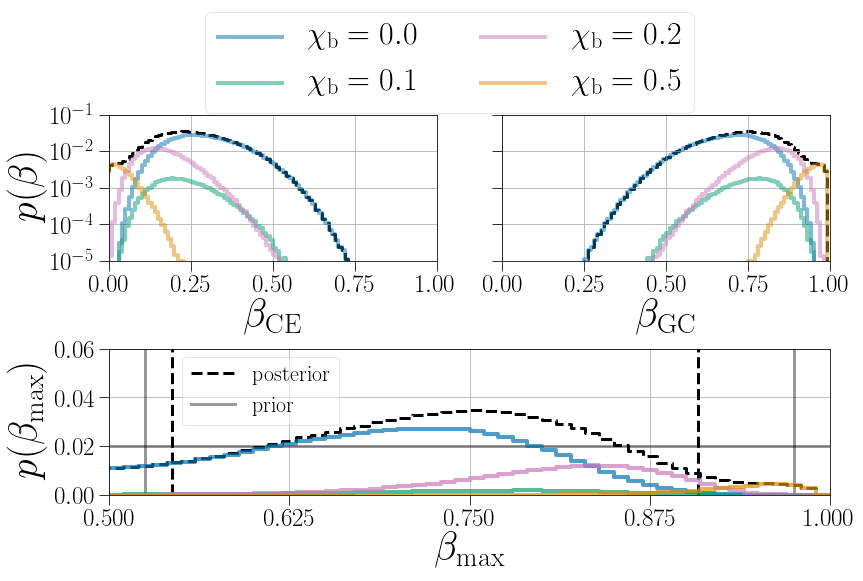

In [293]:
twochannel_branching_fractions(samples_CEGC, 0, \
                         prior_path='/Users/michaelzevin/research/model_selection/model_selection/data/beta_prior/prior_samples_2channel.hdf5', \
                              labelsize=40, ticksize=25, legendsize=32)

In [283]:
# print BFs for CESMT runs
print('Bayes factors for CESMT run...')

# print Bayes factors
samples0 = samples_CESMT.loc[samples_CESMT['p1']==2]
for (hkey, hval) in hyperparam_dict['p1'].items():
    samples_in_hypermodel = samples_CESMT.loc[samples_CESMT['p1']==hkey]
    BF = len(samples_in_hypermodel) / len(samples0)
    print("   For {:s} model, BF={:0.5f}".format(hval,BF))


Bayes factors for CESMT run...
   For $\alpha_\mathrm{CE}=0.2$ model, BF=316.59124
   For $\alpha_\mathrm{CE}=0.5$ model, BF=5911.11922
   For $\alpha_\mathrm{CE}=1.0$ model, BF=1.00000
   For $\alpha_\mathrm{CE}=2.0$ model, BF=0.00000
   For $\alpha_\mathrm{CE}=5.0$ model, BF=0.00000


In [332]:
def branching_fractions(samples, labelsize=40, ticksize=30, legendsize=25, detectable=False):
    beta_keys = sorted([key for key in list(samples.keys()) if 'beta' in key])
    hyperidx_keys = sorted([key for key in list(samples.keys()) if 'beta' not in key])
    
    fig = plt.figure(figsize=(20,10))
    gs = gridspec.GridSpec(len(hyperidx_keys), len(beta_keys), hspace=0.8)
    
    for hidx, hyperparam in enumerate(hyperidx_keys):
        subaxs = []
        for idx in np.arange(len(beta_keys)):
            subaxs.append(fig.add_subplot(gs[hidx, idx]))
            
        if hidx==0:
            colors_tmp = colors[:4]
        elif hidx==1:
            colors_tmp = colors[4:][::-1]
    
        # loop through hyperparameter values
        for (hkey, hval) in hyperparam_dict[hyperparam].items():
            samples_in_hypermodel = samples.loc[samples[hyperparam]==hkey]

            # loops through channels
            for idx, beta in enumerate(beta_keys):
                if idx==2:
                    h, bins = np.histogram(samples_in_hypermodel[beta], bins=100, range=(0,1))
                    h = np.append(h, [0])
                    subaxs[idx].step(bins, h/len(samples), lw=4, alpha=0.5, color=colors_tmp[hkey], label=hval)
                else:
                    h, bins = np.histogram(samples_in_hypermodel[beta], bins=100, range=(0,1))
                    h = np.append(h, [0])
                    subaxs[idx].step(bins, h/len(samples), lw=4, alpha=0.5, color=colors_tmp[hkey])
                    
        # plot total branching fraction
        for idx, beta in enumerate(beta_keys):
            h, bins = np.histogram(samples[beta], bins=100, range=(0,1))
            h = np.append(h, [0])
            subaxs[idx].step(bins, h/len(samples), color='k', alpha=1.0, lw=3, linestyle='--', zorder=-10)
            if hidx==0:
                median = np.median(samples[beta])
                low90 = np.percentile(samples[beta],5)
                high90 = np.percentile(samples[beta],95)
                print("{:s}: {:0.3f}-{:0.3f}+{:0.3f}".format(beta,median, \
                            median-low90, high90-median))
                print("   First percentile: {:0.3f}".format(np.percentile(samples[beta], 1)))
                print("   Percent level constraint: {:0.3f}, {:0.3f}".format(100*np.abs((low90-median)/median), 100*np.abs((high90-median)/median)))
            
            
        # format plot
        for idx, ax in enumerate(subaxs):

            ax.set_xlim(0,1)
            ax.set_yscale('log')
            ax.set_ylim(1e-7, 2e-1)
            ax.set_yticks((1e-7, 1e-5, 1e-3, 1e-1))

            ax.set_xticks((0.0, 0.5, 1.0))
            ax.set_xlabel(hyperparam_dict[beta_keys[idx]], fontsize=labelsize, labelpad=5)
                
            if idx==0:
                ax.set_ylabel(r'$p(\beta)$', fontsize=labelsize)
            else:
                ax.set_yticklabels([])
            ax.tick_params(axis='both', labelsize=ticksize)
                
        if hyperparam=='p0':
            subaxs[2].legend(prop={'size':legendsize}, loc='center', bbox_to_anchor=(0.5, 1.2), ncol=5)
        elif hyperparam=='p1':
            subaxs[2].legend(prop={'size':legendsize}, loc='center', bbox_to_anchor=(0.5, 1.2), ncol=5)
            
            
    # print info for paper
    print("")
    if detectable==False:
        for beta in ['beta_GC', 'beta_NSC']:
            print("Beta increase from chi00 to chi02 in {}, {:0.3f}".format(beta, \
                np.median(samples.loc[samples['p0']==2][beta])-np.median(samples.loc[samples['p0']==0][beta])))
        for beta in ['beta_CE']:
            print("Beta increase from alpha20 to alpha02 in {}, {:0.3f}".format(beta, \
                np.median(samples.loc[samples['p1']==3][beta])-np.median(samples.loc[samples['p1']==0][beta])))
    if detectable==True:
        print("BetaCE for chib=0.0: {:0.3f}".format(np.median(samples.loc[samples['p0']==0]['beta_CE'])))
        
    # print Bayes factors for spin and alpha models
    print("")
    samples0 = samples.loc[samples['p0']==0]
    for (hkey, hval) in hyperparam_dict['p0'].items():
        samples_in_hypermodel = samples.loc[samples['p0']==hkey]
        BF = len(samples_in_hypermodel) / len(samples0)
        print("For {:s} model, BF={:0.5f}".format(hval,BF))
    samples0 = samples.loc[samples['p1']==2]
    for (hkey, hval) in hyperparam_dict['p1'].items():
        samples_in_hypermodel = samples.loc[samples['p1']==hkey]
        BF = len(samples_in_hypermodel) / len(samples0)
        print("For {:s} model, BF={:0.5f}".format(hval,BF))
        
    plt.subplots_adjust(left=0.08, right=0.97)
    if detectable==False:
        plt.savefig(os.path.join(fig_path, 'beta_posteriors.png'))
    elif detectable==True:
        plt.savefig(os.path.join(fig_path, 'beta_posteriors_detectable.png'))
    

beta_CE: 0.191-0.128+0.163
   First percentile: 0.013
   Percent level constraint: 67.105, 85.092
beta_CHE: 0.042-0.036+0.079
   First percentile: 0.001
   Percent level constraint: 85.697, 187.888
beta_GC: 0.520-0.200+0.196
   First percentile: 0.240
   Percent level constraint: 38.491, 37.625
beta_NSC: 0.108-0.098+0.207
   First percentile: 0.002
   Percent level constraint: 90.711, 192.182
beta_SMT: 0.083-0.077+0.194
   First percentile: 0.001
   Percent level constraint: 92.812, 232.915

Beta increase from chi00 to chi02 in beta_GC, 0.066
Beta increase from chi00 to chi02 in beta_NSC, 0.121
Beta increase from alpha20 to alpha02 in beta_CE, 0.185

For $\chi_\mathrm{b}=0.0$ model, BF=1.00000
For $\chi_\mathrm{b}=0.1$ model, BF=0.30025
For $\chi_\mathrm{b}=0.2$ model, BF=0.37805
For $\chi_\mathrm{b}=0.5$ model, BF=0.06652
For $\alpha_\mathrm{CE}=0.2$ model, BF=0.39801
For $\alpha_\mathrm{CE}=0.5$ model, BF=3.18250
For $\alpha_\mathrm{CE}=1.0$ model, BF=1.00000
For $\alpha_\mathrm{CE}=

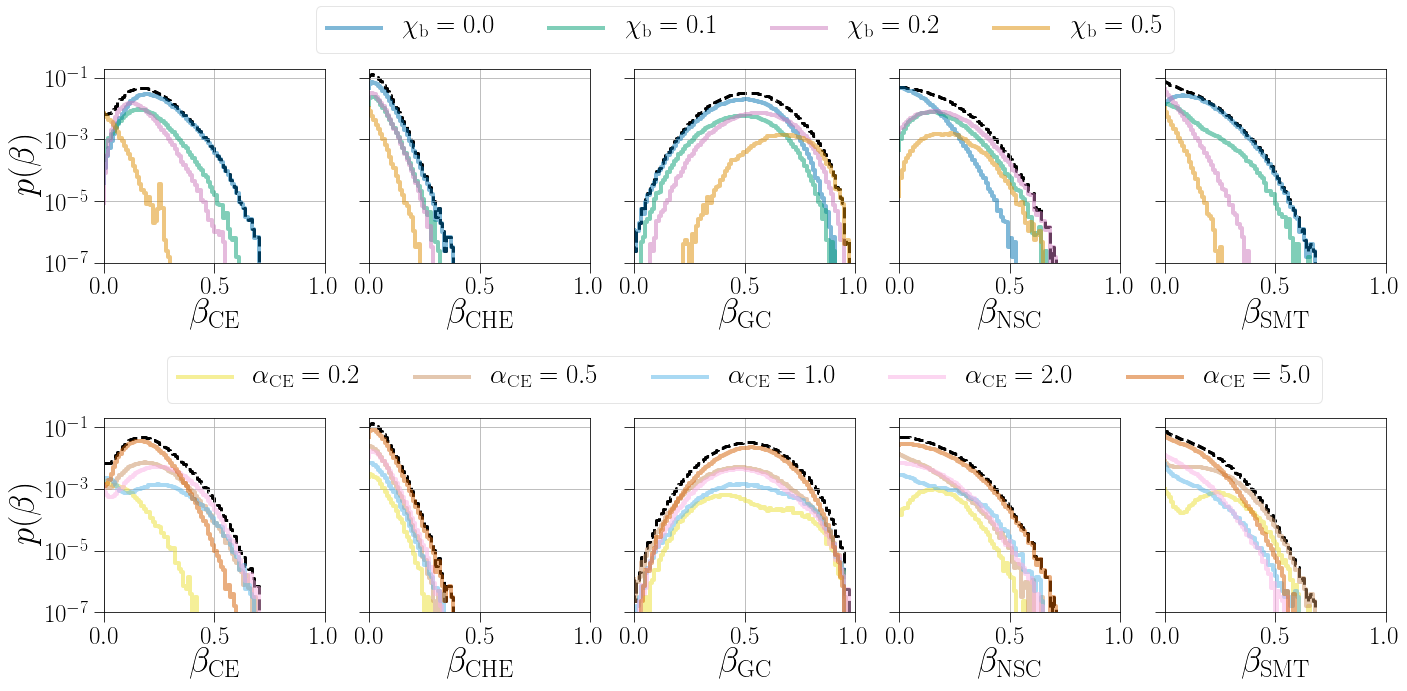

In [313]:
branching_fractions(samples, labelsize=35, ticksize=25, legendsize=27, detectable=False)

beta_CE: 0.043-0.031+0.064
   First percentile: 0.002
   Percent level constraint: 72.452, 151.078
beta_CHE: 0.007-0.006+0.017
   First percentile: 0.000
   Percent level constraint: 86.806, 237.412
beta_GC: 0.893-0.116+0.057
   First percentile: 0.699
   Percent level constraint: 12.952, 6.423
beta_NSC: 0.035-0.032+0.087
   First percentile: 0.001
   Percent level constraint: 91.452, 252.369
beta_SMT: 0.010-0.010+0.033
   First percentile: 0.000
   Percent level constraint: 93.769, 329.917

BetaCE for chib=0.0: 0.052

For $\chi_\mathrm{b}=0.0$ model, BF=1.00000
For $\chi_\mathrm{b}=0.1$ model, BF=0.30025
For $\chi_\mathrm{b}=0.2$ model, BF=0.37805
For $\chi_\mathrm{b}=0.5$ model, BF=0.06652
For $\alpha_\mathrm{CE}=0.2$ model, BF=0.39801
For $\alpha_\mathrm{CE}=0.5$ model, BF=3.18250
For $\alpha_\mathrm{CE}=1.0$ model, BF=1.00000
For $\alpha_\mathrm{CE}=2.0$ model, BF=2.54437
For $\alpha_\mathrm{CE}=5.0$ model, BF=12.30212


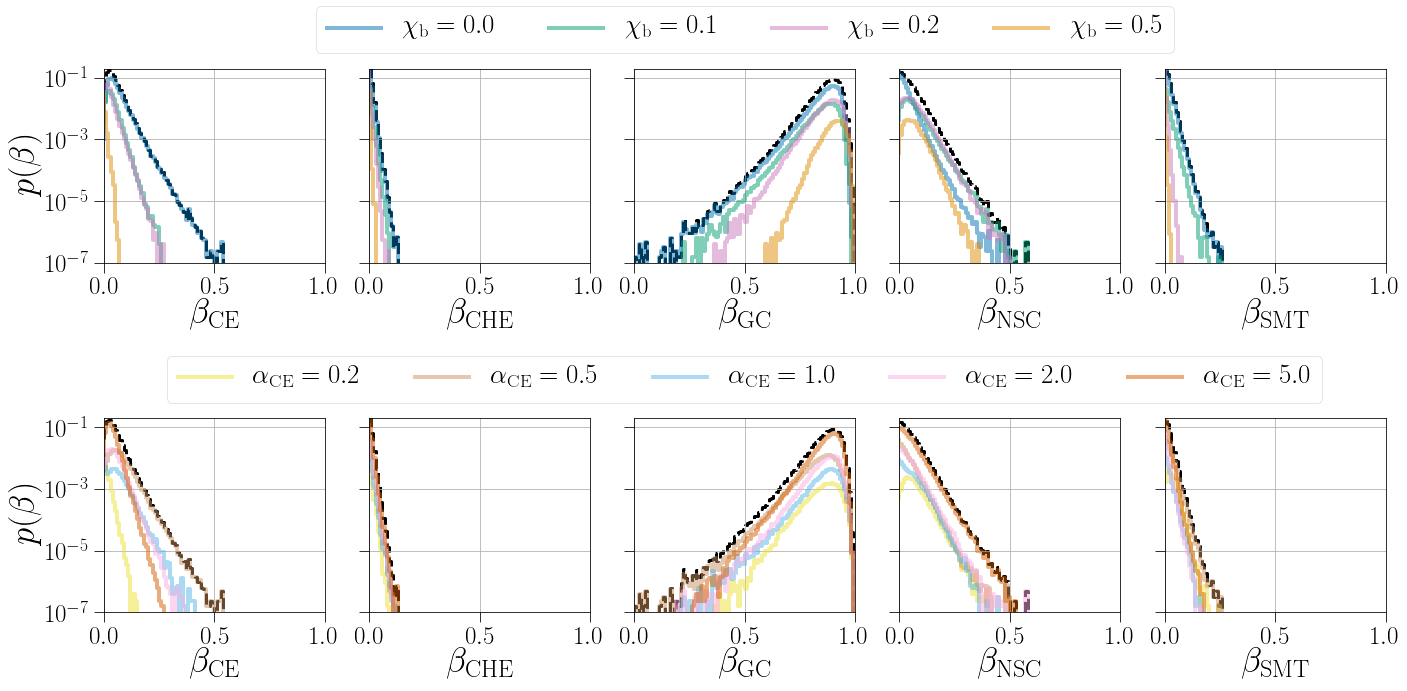

In [333]:
branching_fractions(samples_detectable, labelsize=35, ticksize=25, legendsize=27, detectable=True)

In [337]:
print("Percent increase for CE when chi=0: {:0.3f}".format(100*np.abs((0.043-0.052) / 0.052)))

Percent increase for CE when chi=0: 17.308


In [303]:
# print difference in branching fractions between the two-channel and five-channel case for CE and GC

print('Percent difference in CE branching fraction: {:0.3f}'.format(100*np.abs((0.191-0.261)/0.261)))
print('Percent difference in GC branching fraction: {:0.3f}'.format(100*np.abs((0.520-0.739)/0.739)))
print('Increase in chib=0.1 model: {:0.3f}'.format(0.30025/0.05095))

Percent difference in CE branching fraction: 26.820
Percent difference in GC branching fraction: 29.635
Increase in chib=0.1 model: 5.893


In [321]:
def largest_beta(samples, hyperidx, prior_path, labelsize=40, ticksize=30, legendsize=25):
    beta_keys = sorted([key for key in list(samples.keys()) if 'beta' in key])
    hyperidx_key = 'p'+str(int(hyperidx))

    fig = plt.figure(figsize=(10,6))
    gs = gridspec.GridSpec(3, 1)
    Bmax_ax = fig.add_subplot(gs[:,:])
    #Bvol_ax = fig.add_subplot(gs[0,:])
    
    
    ### BOTTOM ROW
    
    # get max beta for all samples
    betas = samples[beta_keys]
    max_betas = betas.max(axis=1)
    h, bins = np.histogram(max_betas, bins=100, range=(0,1))
    h = np.append(h, [0])
    Bmax_ax.step(bins, h/len(samples), color='k', alpha=1.0, lw=3, linestyle='--', label='posterior')
    Bmax_ax.axvline(np.percentile(max_betas, 5), color='k', alpha=1.0, lw=3, linestyle='--')
    Bmax_ax.axvline(np.percentile(max_betas, 95), color='k', alpha=1.0, lw=3, linestyle='--')
    print("90% of beta_max for the posterior are below: {:0.3f}".format(np.percentile(max_betas, 90)))
    print("99% of beta_max for the posterior are below: {:0.3f}".format(np.percentile(max_betas, 99)))
    
    # get max beta for prior samples
    prior_samps = pd.read_hdf(prior_path, key='samples')
    max_betas = prior_samps.max(axis=1)
    h, bins = np.histogram(max_betas, bins=100, range=(0,1))
    h = np.append(h, [0])
    Bmax_ax.step(bins, h/len(samples), color='k', alpha=0.4, lw=3, label='prior')
    Bmax_ax.axvline(np.percentile(max_betas, 5), color='k', alpha=0.4, lw=3)
    Bmax_ax.axvline(np.percentile(max_betas, 95), color='k', alpha=0.4, lw=3)
    print("90% of beta_max for the prior are below: {:0.3f}".format(np.percentile(max_betas, 90)))
    print("99% of beta_max for the prior are below: {:0.3f}".format(np.percentile(max_betas, 99)))
    
    # get max betas for submodels
    for (hkey, hval) in hyperparam_dict[hyperidx_key].items():
        samples_in_hypermodel = samples.loc[samples[hyperidx_key]==hkey]
        betas = samples_in_hypermodel[beta_keys]
        max_betas = betas.max(axis=1)
        h, bins = np.histogram(max_betas, bins=100, range=(0,1))
        h = np.append(h, [0])
        Bmax_ax.step(bins, h/len(samples), color=colors[hkey], alpha=0.7, lw=4, label=hval)
        
    # format plot
    Bmax_ax.set_xlim(1/len(beta_keys),1)
    Bmax_ax.set_xticks((np.linspace(1/len(beta_keys), 1, 5)))
    Bmax_ax.set_ylim(0, 0.04)
    Bmax_ax.set_yticks((0, 0.01, 0.02, 0.03, 0.04))
    Bmax_ax.set_xlabel(r'$\beta_{\rm max}$', fontsize=labelsize)
    Bmax_ax.set_ylabel(r'$p(\beta_{\rm max})$', fontsize=labelsize)
    Bmax_ax.tick_params(axis='both', labelsize=ticksize)
    
    Bmax_ax.legend(prop={'size':legendsize}, loc='upper right')
        
        
        
    """### TOP ROW
    prior_samps = pd.read_hdf(prior_path, key='samples')
    max_betas = prior_samps.max(axis=1)
    h_prior, _ = np.histogram(max_betas, bins=100, range=(1.0/len(beta_keys),1))   
    prior_vol = np.cumsum(h_prior[::-1])[::-1]
    
    # get max beta for all samples
    betas = samples[beta_keys]
    max_betas = betas.max(axis=1)
    h_post, bins = np.histogram(max_betas, bins=100, range=(1.0/len(beta_keys),1))
    post_vol = np.cumsum(h_post[::-1])[::-1]
    
    # print prior volume comparison
    binval = 0.8
    bin_idx = np.where(bins>=binval)[0][0]
    print("Prior volume compared to posterior volume at beta_max={:.02f}: {:0.3f}".format(binval, float(prior_vol[bin_idx] / post_vol[bin_idx])))
    
    # get the heights and bins where there is any posterior volume
    where_theres_post = np.where(h_post > 0)[0]
    where_theres_nopost = np.where(h_post == 0)[0]
    
    bins_to_plot = np.append(bins[0], bins[1:][where_theres_post])
    bins_to_plot = np.append(bins_to_plot, [bins[where_theres_post][-1]+(bins[1]-bins[0])])
    priorpost_to_plot = np.append([1], prior_vol[where_theres_post] / post_vol[where_theres_post])
    priorpost_to_plot = np.append(priorpost_to_plot, [1e4])

    Bvol_ax.plot(bins_to_plot, priorpost_to_plot, color='k')

    # format plot
    Bvol_ax.set_xlim(1/len(beta_keys),1)
    Bvol_ax.set_xticks((np.linspace(1/len(beta_keys), 1, 5)))
    Bvol_ax.set_xticklabels([])
    Bvol_ax.set_yscale('log')
    Bvol_ax.set_ylim(9e-1, 1e4)
    Bvol_ax.set_yticks([1e0, 1e2, 1e4])
    Bvol_ax.set_ylabel(r'$\mathcal{V}$', fontsize=labelsize)
    Bvol_ax.tick_params(axis='both', labelsize=ticksize)"""
    
    plt.tight_layout(rect=(0, 0, 1, 1))
    plt.savefig(os.path.join(fig_path, 'beta_max.png'))

90% of beta_max for the posterior are below: 0.673
99% of beta_max for the posterior are below: 0.793
90% of beta_max for the prior are below: 0.624
99% of beta_max for the prior are below: 0.789


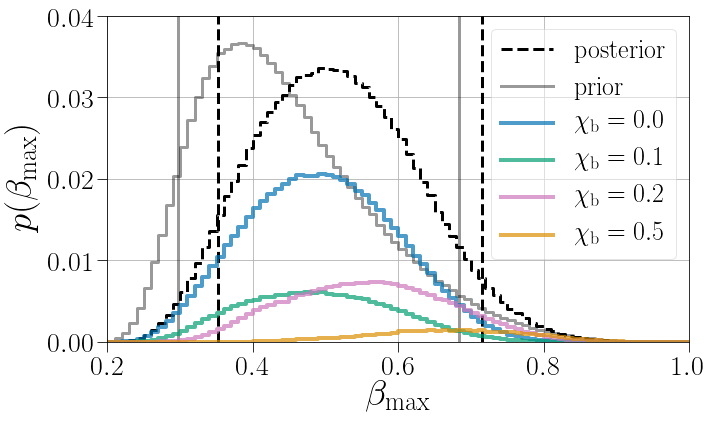

In [322]:
largest_beta(samples, 0, \
            prior_path='/Users/michaelzevin/research/model_selection/model_selection/data/beta_prior/prior_samples_5channel.hdf5', \
            labelsize=37, ticksize=28, legendsize=26)

### Posterior on the number of channels whose branching fractions are simultaneously above some threshold

In [319]:
def print_significant_contribution(samples, threshold=0.1, param_dict={'p0':None, 'p1':None}):
    
    beta_keys = [key for key in samples.keys() if 'beta' in key]
    
    # cut the samples, if specified, otherwise marginalize over all params
    for key, val in param_dict.items():
        if param_dict[key] is not None:
            samples = samples.loc[samples[key]==val]
            
    N_gtr_thresh = np.asarray(np.sum(samples[beta_keys] > threshold, axis=1))
    
    # print percentages for each
    for i in (np.arange(len(beta_keys))+1):
        Nsamps = np.sum(N_gtr_thresh==i)
        print('Percentage of samples where {:d} channels have branching fractions greater than {:0.3f}: {:0.3f}'.format(i, threshold, 100*(Nsamps/len(samples))))

In [320]:
print_significant_contribution(samples, threshold=0.1, param_dict={'p0':None, 'p1':None})

Percentage of samples where 1 channels have branching fractions greater than 0.100: 1.003
Percentage of samples where 2 channels have branching fractions greater than 0.100: 24.908
Percentage of samples where 3 channels have branching fractions greater than 0.100: 54.435
Percentage of samples where 4 channels have branching fractions greater than 0.100: 18.383
Percentage of samples where 5 channels have branching fractions greater than 0.100: 1.270


### Table for Bayes Factors

In [250]:
p1_dict = {0:'0.2', 1:'0.5', 2:'1.0', 3:'2.0', 4:'5.0'}

def construct_table(models, model0_dict):
    
    table = \
r'''\begin{table}[t]
\begin{center}
\caption{Bayes factors ($\log_{10}(\mathcal{B})$) across \chib models (columns) and \alphaCE models (rows), relative to the model with $\chib=0.0$ and $\alphaCE=1.0$. 
The bottom row provides the Bayes factors for \chib models marginalized over all \alphaCE models, and the rightmost column provides the Bayes factors for \alphaCE models marginalized over all \chib models. 
%Bayes factors are marked as `$-$' when no samples are in the given model, implying a strongly negative Bayes factor of $\log_{10}(\mathcal{B}) < -4.68$. 
\label{tab:table}}
\setlength{\tabcolsep}{6pt}
\vspace{-10pt}
\begin{tabular}{c c c c c c c} 
& & \multicolumn{4}{c}{$\chi_{\rm b}$} & \\
& \multicolumn{1}{l|}{} & $0.0$ & $0.1$ & $0.2$ & \multicolumn{1}{l|}{$0.5$} & \\
\cline{2-7}
'''
    p0_vals = [0,1,2,3]
    p1_vals = [0,1,2,3,4]
    
    Nsamps0 = len(samples.loc[(samples['p0']==model0_dict['p0']) & (samples['p1']==model0_dict['p1'])])
    Nsamps0_p0 = len(samples.loc[samples['p0']==model0_dict['p0']])
    Nsamps0_p1 = len(samples.loc[samples['p1']==model0_dict['p1']])
    
    for p1 in p1_vals:
        BF_vals = []
        # add values for each alphaCE
        for p0 in p0_vals:
            Nsamps = len(samples.loc[(samples['p0']==p0) & (samples['p1']==p1)])
            if Nsamps == 0:
                BF_vals.append(-100)
            else:
                BF_vals.append(np.log10(Nsamps/Nsamps0))
        # add value for this row in alphaCE
        Nsamps = len(samples.loc[(samples['p1']==p1)])
        if Nsamps == 0:
            BF_vals.append(-100)
        else:
            BF_vals.append(np.log10(Nsamps/Nsamps0_p1))
        
        # reformat the BF values
        BF_vals_formatted = []
        for BF in BF_vals:
            if BF==0:
                BF_vals_formatted.append(r'\equiv')
            elif BF==-100:
                BF_vals_formatted.append('-')
            else:
                BF_vals_formatted.append('{:0.2f}'.format(np.round(BF, 2)))
        
        if p1 == 0:
            temp = r'''\multirow{5}{*}{$\alpha_{\rm CE}$} & \multicolumn{1}{l|}{$%s$} & $%s$ & $%s$ & $%s$ & \multicolumn{1}{l|}{$%s$} & $%s$ \\
''' % (p1_dict[p1], BF_vals_formatted[0], BF_vals_formatted[1], BF_vals_formatted[2], \
                                   BF_vals_formatted[3], BF_vals_formatted[4])
        else:
            temp = r'''& \multicolumn{1}{l|}{$%s$} & $%s$ & $%s$ & $%s$ & \multicolumn{1}{l|}{$%s$} & $%s$ \\
''' % (p1_dict[p1], BF_vals_formatted[0], BF_vals_formatted[1], BF_vals_formatted[2], \
                                   BF_vals_formatted[3], BF_vals_formatted[4])
        table += temp

    table += r'''\cline{2-7}
'''
    
    # add values for all chib columns
    BF_vals = []
    for p0 in p0_vals:
        Nsamps = len(samples.loc[(samples['p0']==p0)])
        if Nsamps == 0:
            BF_vals.append(-100)
        else:
            BF_vals.append(np.log10(Nsamps/Nsamps0_p0))
    BF_vals_formatted = []
    for BF in BF_vals:
        if BF==0:
            BF_vals_formatted.append(r'\equiv')
        elif BF==-100:
            BF_vals_formatted.append('-')
        else:
            BF_vals_formatted.append('{:0.2f}'.format(np.round(BF, 2)))
    temp = r'''& \multicolumn{1}{l|}{$%s$} & $%s$ & $%s$ & $%s$ & \multicolumn{1}{l|}{$%s$} & $%s$ ''' \
            % ('', BF_vals_formatted[0], BF_vals_formatted[1], BF_vals_formatted[2], BF_vals_formatted[3], '')
    table += temp

    temp = r'''
\end{tabular}
\end{center}
\end{table}'''
    table += temp

    print(str(table))
    return

In [251]:
construct_table(samples, {'p0':0, 'p1':2})

\begin{table}[t]
\begin{center}
\caption{Bayes factors ($\log_{10}(\mathcal{B})$) across \chib models (columns) and \alphaCE models (rows), relative to the model with $\chib=0.0$ and $\alphaCE=1.0$. 
The bottom row provides the Bayes factors for \chib models marginalized over all \alphaCE models, and the rightmost column provides the Bayes factors for \alphaCE models marginalized over all \chib models. 
%Bayes factors are marked as `$-$' when no samples are in the given model, implying a strongly negative Bayes factor of $\log_{10}(\mathcal{B}) < -4.68$. \label{tab:table}}
\setlength{\tabcolsep}{6pt}
\vspace{-20pt}
\begin{tabular}{c c c c c c c} 
& & \multicolumn{4}{c}{$\chi_{\rm b}$} & \\
& \multicolumn{1}{l|}{} & $0.0$ & $0.1$ & $0.2$ & \multicolumn{1}{l|}{$0.5$} & \\
\cline{2-7}
\multirow{5}{*}{$\alpha_{\rm CE}$} & \multicolumn{1}{l|}{$0.2$} & $-1.31$ & $-0.30$ & $-3.86$ & \multicolumn{1}{l|}{$-0.85$} & $-0.40$ \\
& \multicolumn{1}{l|}{$0.5$} & $0.62$ & $-1.02$ & $0.04$ & \multicolu

### Mock Samples

In [242]:
data_path = '/Users/michaelzevin/research/model_selection/model_selection/trials/chi00_alpha10_delta'
Nobs = sorted([int(n) for n in os.listdir(data_path)])

In [246]:
# Branching fractions

def branching_fractions_mockobs(hyperidx, Nobs):
    
    if hyperidx==0:
        colors_tmp = colors[:4]
    elif hyperidx==1:
        colors_tmp = colors[4:][::-1]
    
    # plotting
    fig, axs = plt.subplots(len(Nobs),5, figsize=(4*5,4*len(Nobs)))
    
    for sidx, (subaxs, N) in enumerate(zip(axs, Nobs)):
    
        # get the hdf5 files for this run
        run_files = os.listdir(os.path.join(data_path, str(N)))
        sample_files = []
        for file in run_files:
            if '.hdf5' in file:
                sample_files.append(file)

        samples = pd.DataFrame()

        for fidx, file in enumerate(sample_files):
            if fidx==0:
                # save model0 info, assuming all in this folder are the same
                f = h5py.File(os.path.join(data_path, str(N), file))
                model0_info = f['model_selection'].attrs['model0_params']
                f.close()
            tmp = pd.read_hdf(os.path.join(data_path, str(N), file), key='model_selection/samples')
            samples = samples.append(tmp)

        samples = samples.reset_index(drop=True)

        beta_keys = sorted([key for key in list(samples.keys()) if 'beta' in key])
        hyperidx_col = 'p'+str(int(hyperidx))


        # store true values in dict
        beta_true = {}
        for beta in beta_keys:
            for hyperp in list(model0_info):
                if beta[-2:] in str(hyperp):
                    beta_true[beta] = float(hyperp[-3:])


        # loop through hyperparameter values
        for (hkey, hval) in hyperparam_dict[hyperidx_col].items():
            samples_in_hypermodel = samples.loc[samples[hyperidx_col]==hkey]

            # loops through channels
            for cidx, beta in enumerate(beta_keys):
                if cidx==0:
                    _ = subaxs[cidx].hist(samples_in_hypermodel[beta], bins=50, histtype='step', range=(0,1), lw=4, alpha=0.5, color=colors_tmp[hkey], label=hval)
                else:
                    _ = subaxs[cidx].hist(samples_in_hypermodel[beta], bins=50, histtype='step', range=(0,1), lw=4, alpha=0.5, color=colors_tmp[hkey])
                if hkey==0:
                    subaxs[cidx].axvline(beta_true[beta], color='k', linestyle='--')



        # format plot
        for idx, ax in enumerate(subaxs):
            ax.set_xlim(0,1)
            ax.set_xticks((0.0, 0.5, 1.0))
            ax.set_yscale('log')
            ax.set_ylim(1e0, 1e6)
            ax.set_yticks([1e0, 1e2, 1e4, 1e6])
            if idx!=0:
                ax.set_yticklabels([])
            else:
                ax.set_yticklabels(['$10^0$', '$10^2$', '$10^4$', '$10^6$'])
            if idx==0:
                ax.set_ylabel(r'$N_{\rm obs}$' + ' = %d \n counts' % (N))
            if sidx==len(axs)-1:
                ax.set_xlabel(hyperparam_dict[beta_keys[idx]])
                ax.set_xticklabels([0.0, 0.5, 1.0])
            else:
                ax.set_xticklabels([])
            
        # legend
        if sidx==0:
            if hyperidx_col=='p0':
                fig.legend(bbox_to_anchor=(0.53, 0.97), loc='center', ncol=len(hyperparam_dict[hyperidx_col].keys()), prop={'size':35})
            elif hyperidx_col=='p1':
                fig.legend(bbox_to_anchor=(0.535, 0.97), loc='center', ncol=len(hyperparam_dict[hyperidx_col].keys()), prop={'size':29})
            
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(os.path.join(fig_path, 'mock_samples_'+hyperidx_col+'.png'))

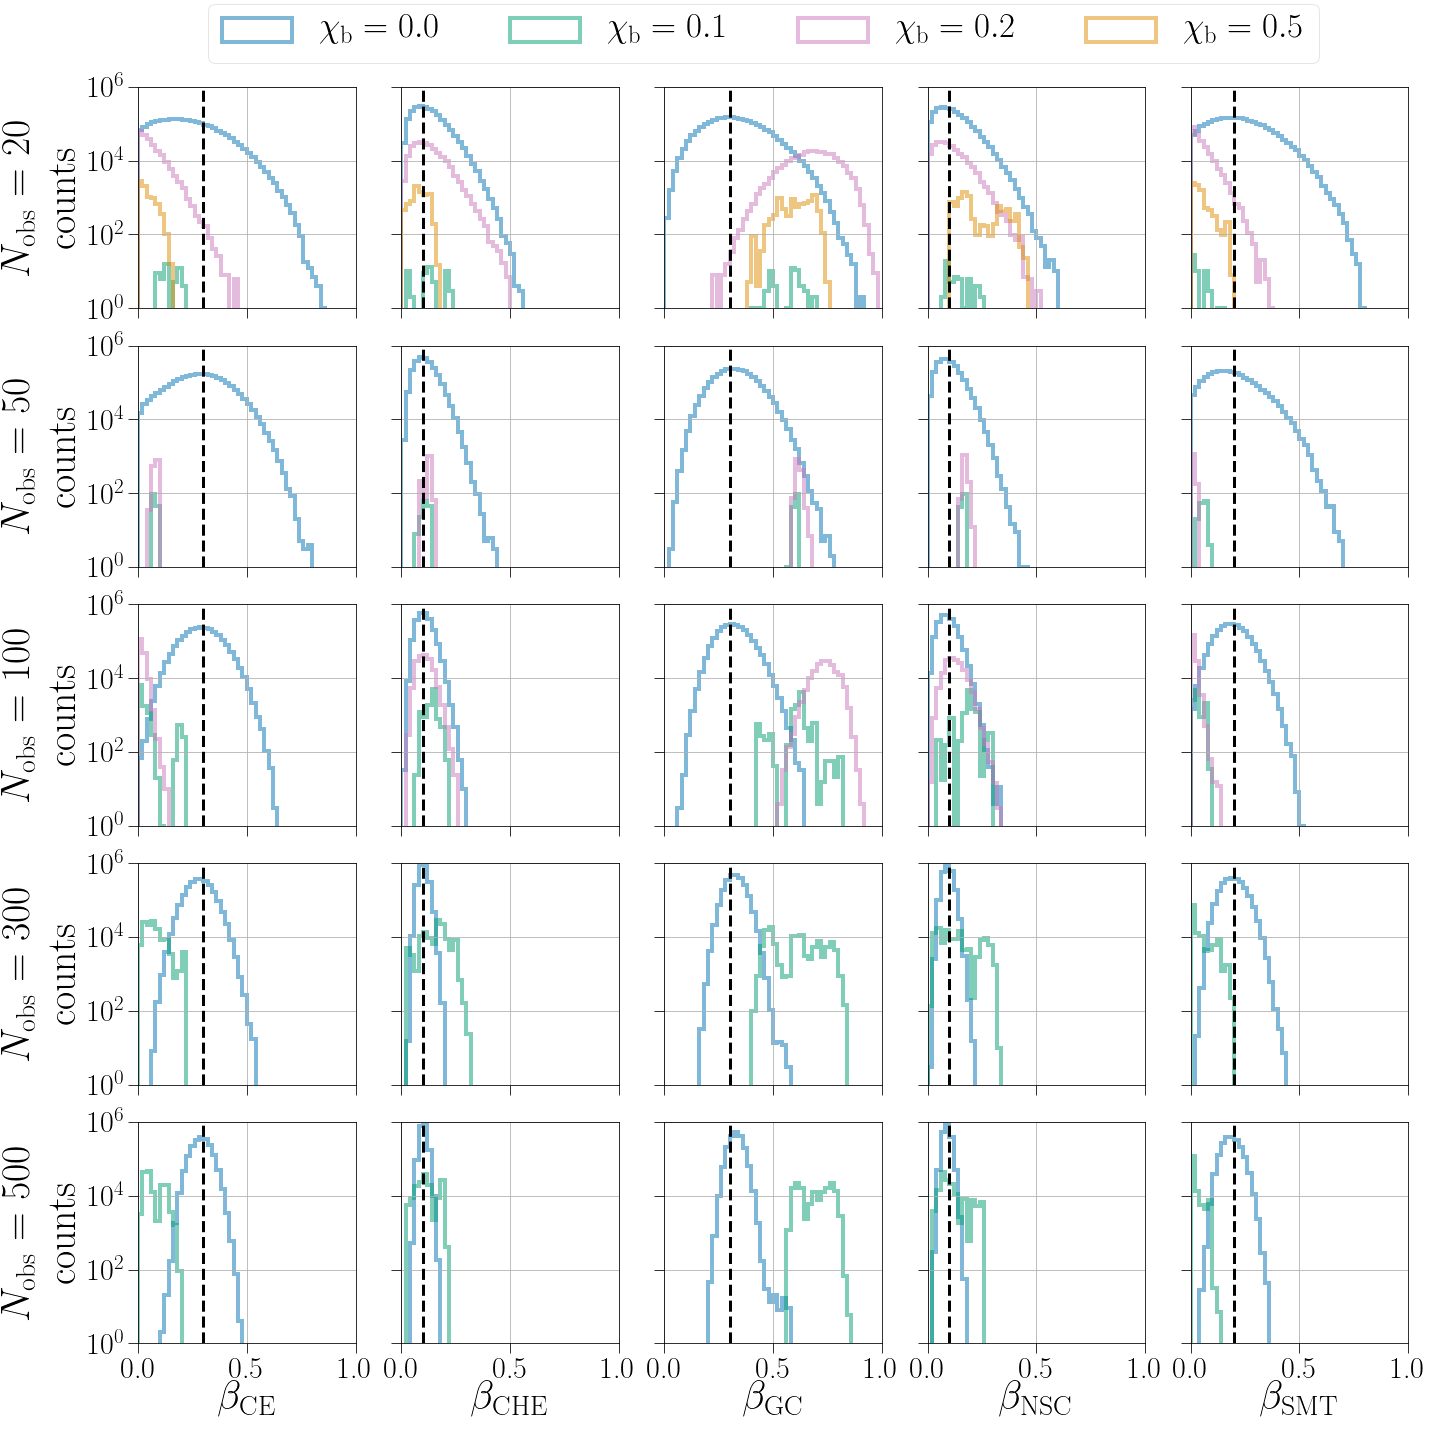

In [248]:
branching_fractions_mockobs(0, Nobs)

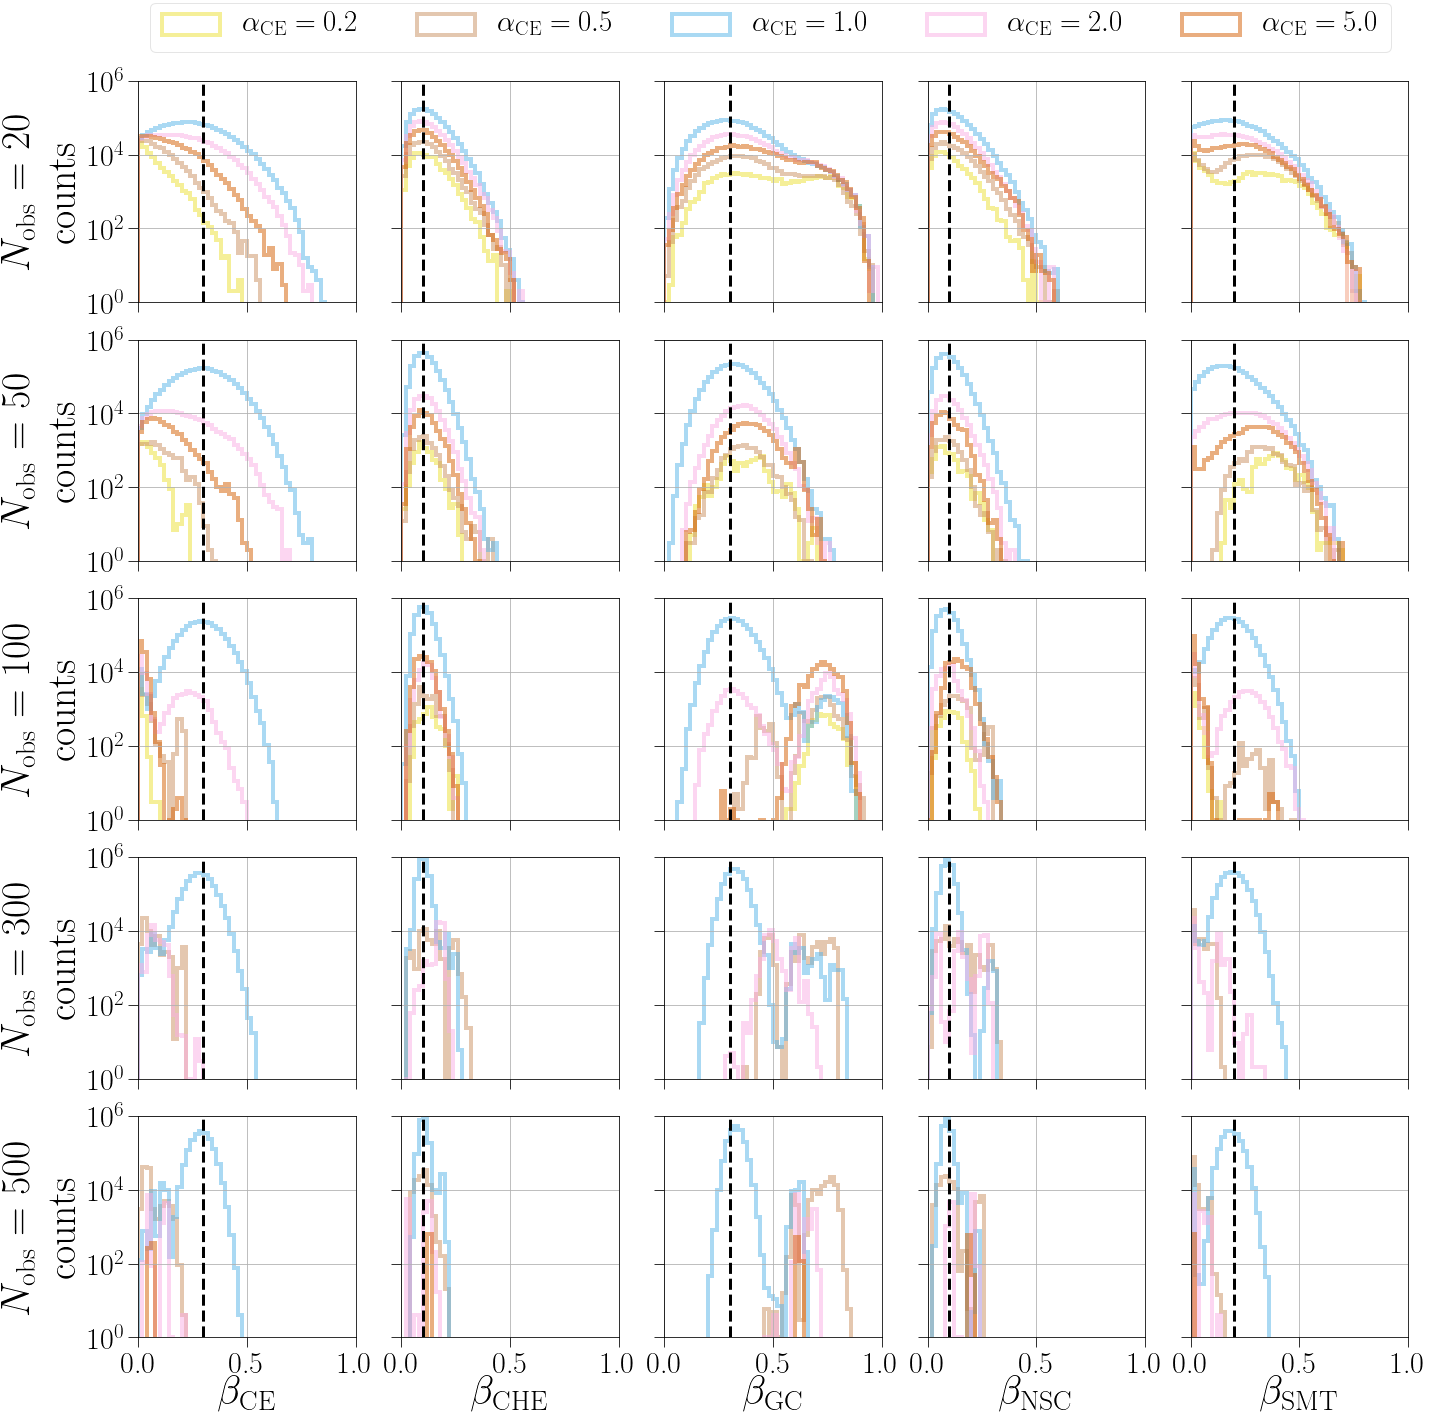

In [249]:
branching_fractions_mockobs(1, Nobs)